# Loading and training a demo subset of ENS10
In this notebook, we will see how the ENS10 dataset is structured and trained through **ENS5-mini** - a smaller (10 GB) subset of ENS10 (3 TB). We will begin by loading the data with CliMetLab:

In [1]:
!pip install climetlab
!pip install climetlab-maelstrom-ens10

In [2]:
import climetlab as cml

## Loading

In [3]:
cmlds = cml.load_dataset('maelstrom-ens5mini', '01')

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/spcl/climetlab-maelstrom-ens10/blob/main/ENS10_LICENCE.txt If you do not agree with such terms, do not download the data. 


ens5mini.01.nc:   0%|          | 0.00/846M [00:00<?, ?B/s]

The dataset contains one file per month, with the same structure as ENS10. We can, for example, plot the temperature at 850 hPa (index 2 in the dataset) of the first three ensemble members using the following command:

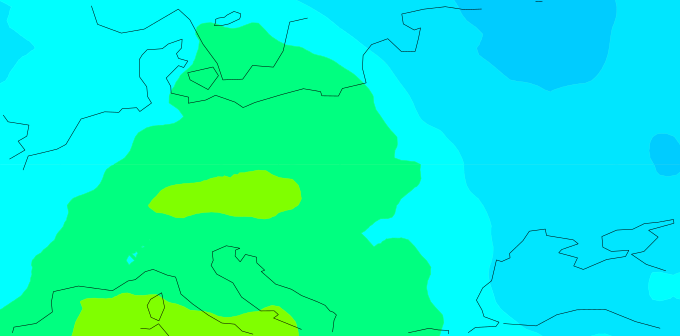

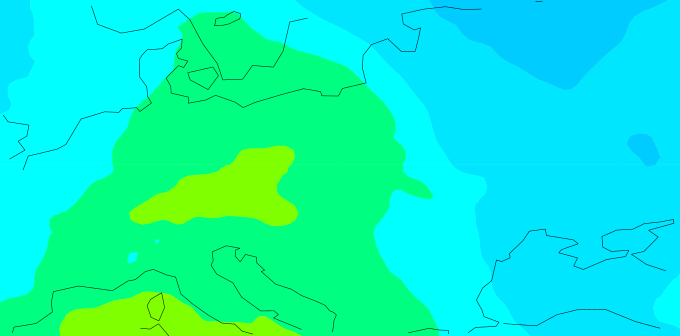

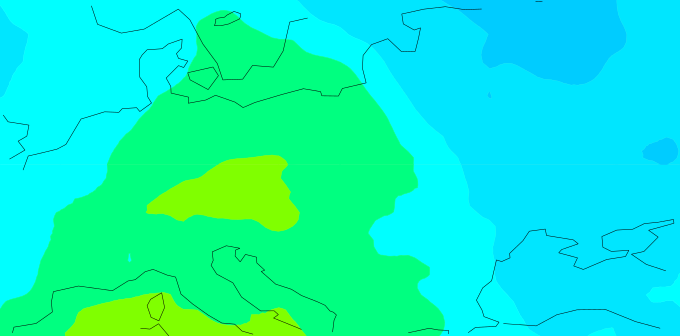

In [4]:
ds = cmlds.to_xarray()
cml.plot_map(ds['t'][0, 0, 0, 2])
cml.plot_map(ds['t'][1, 0, 0, 2])
cml.plot_map(ds['t'][2, 0, 0, 2])

## Training

With the data available, we can now train a simple neural network to predict the standard deviation of the ensemble members 24 hours into the future. Let's first define the goal by plotting the standard deviation between ensemble members on January 1st, 1998:

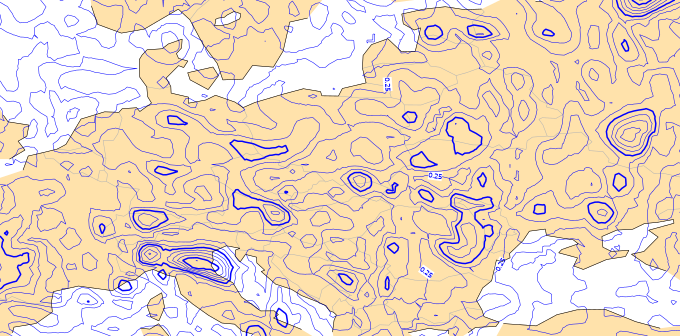

In [5]:
target = ds['t'][:, 0, 0, 2].std('number')
cml.plot_map(target)

Using PyTorch, we can create a simple fully-connected DNN that takes a day's standard deviation, and approximates the standard deviation at 24 hour lead time:

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

In [7]:
class SimpleModel(torch.nn.Module):
    def __init__(self, input_size, input_shape, hidden_size=256):
        super().__init__()
        self.input_size = input_size
        self.input_shape = input_shape
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        x = x.reshape(-1, self.input_size)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        return self.linear3(x).reshape(-1, *self.input_shape)

First, we need to prepare and normalize our dataset. The data would be filtered to a single pressure level, then split into our source (time `t`) and target (time `t`+24h), in which we will only consider temperature:

In [8]:
onepl = ds.isel(isobaricInhPa=2)
x = onepl.std('number').isel(step=0)['t'].sortby('time')
y = onepl.std('number').isel(step=1)['t'].sortby('time')

# Set training and validation datasets
x_train = x[:80]
x_val = x[80:]
y_train = y[:80]
y_val = y[80:]

y_train

<xarray.DataArray 't' (time: 80, latitude: 40, longitude: 80)>
dask.array<getitem, shape=(80, 40, 80), dtype=float32, chunksize=(80, 40, 80), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) datetime64[ns] 1998-01-01 1998-01-04 ... 2006-01-25
    step           timedelta64[ns] 1 days
    isobaricInhPa  float64 850.0
  * latitude       (latitude) float64 60.0 59.5 59.0 58.5 ... 41.5 41.0 40.5
  * longitude      (longitude) float64 0.0 0.5 1.0 1.5 ... 38.0 38.5 39.0 39.5
    valid_time     (time) datetime64[ns] dask.array<chunksize=(80,), meta=np.ndarray>

Now we should normalize our dataset. In this notebook, we use standardization:

In [9]:
import numpy as np

xmean = np.mean(x_train.values)
xstd = np.std(x_train.values)
normed_xtrain = (x_train.values - xmean) / (xstd + 1e-6)
normed_xval = (x_val.values - xmean) / (xstd + 1e-6)

ymean = np.mean(y_train.values)
ystd = np.std(y_train.values)
normed_ytrain = (y_train.values - ymean) / (ystd + 1e-6)
normed_yval = (y_val.values - ymean) / (ystd + 1e-6)

Now we will run a standard training loop with MSE error and the Adam optimizer:

In [10]:
from torch.utils.data import DataLoader

train_loader_x = DataLoader(normed_xtrain, batch_size=4)
train_loader_y = DataLoader(normed_ytrain, batch_size=4)
val_loader_x = DataLoader(normed_xval, batch_size=1)
val_loader_y = DataLoader(normed_yval, batch_size=1)

# Set up model and optimizer
model = SimpleModel(x_train.shape[1] * x_train.shape[2], x_train.shape[1:], 128)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def train_model(epoch):
    err = 0.0
    cnt = 0
    
    model.train()
    for x, y in zip(train_loader_x, train_loader_y):
        loss = F.mse_loss(model(x), y)
        err += loss
        loss.backward()
        optimizer.step()
        cnt += 1
    print(f'Training error at epoch {epoch}: {err / cnt}')


def test_model(epoch):
    err = 0.0
    cnt = 0
    
    model.eval()
    for x, y in zip(val_loader_x, val_loader_y):
        err += F.mse_loss(model(x), y)
        cnt += 1
    print(f'Validation error at epoch {epoch}: {err / cnt}')

    
test_model(0)
for i in range(1, 5):
    train_model(i)
    test_model(i)

Validation error at epoch 0: 1.1850581169128418
Training error at epoch 1: 1.0172224044799805
Validation error at epoch 1: 1.173112154006958
Training error at epoch 2: 1.0064458847045898
Validation error at epoch 2: 1.176439642906189
Training error at epoch 3: 1.002234935760498
Validation error at epoch 3: 1.1768686771392822
Training error at epoch 4: 0.9963768124580383
Validation error at epoch 4: 1.1742274761199951
